# Pyomo Model of the Double Pipe Heat Exchanger

This is additional material regarding the modeling and analysis of the double pipe heat exchanger.

## Temperature Dependence Heat Transfer Coefficient

### Dittus-Boelter Equation

$$Nu = C\cdot Re^{4/5}\cdot Pr^{2/5}$$

The Prandtl number for water is a reasonably strong function of temperature over the operating range of this heat exchanger.

$$Pr = \frac{\mu c_p}{k}$$

where

$$
\begin{align*}
\mu & = \text{viscosity} & \frac{\text{kg}}{\text{m}\cdot\text{s}} \\
c_p & = \text{specific heat} & \frac{\text{J}}{\text{kg}\cdot\text{K}} \\
k & = \text{thermal conductivity} & \frac{\text{W}}{\text{m}\cdot\text{K}} \\
\end{align*}
$$

### Physical property equations from

Pátek, J., Hrubý, J., Klomfar, J., Součková, M., & Harvey, A. H. (2009). Reference correlations for thermophysical properties of liquid water at 0.1 MPa. Journal of Physical and Chemical Reference Data, 38(1), 21-29. https://aip.scitation.org/doi/10.1063/1.3043575

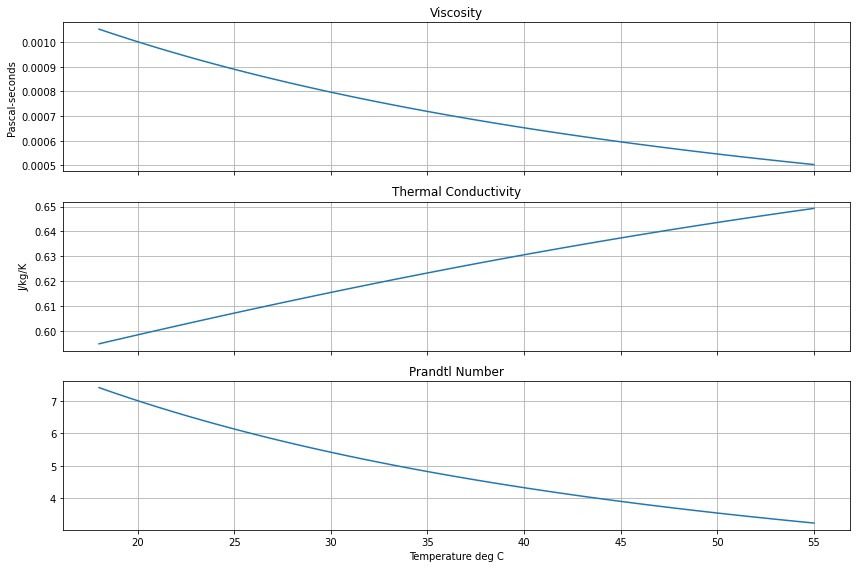

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt

cp = 4183.0 # J/kg/K

def viscosity(T):
    ac = [280.68, 511.45, 61.131, 0.45903]
    bc = [-1.9, -7.7, -19.6, -40.0]
    Tr = (T + 273.15)/300
    return 1e-6*sum(a*Tr**b for a, b in zip(ac, bc))

def thermal_conductivity(T):
    Tr = (T + 273.15)/300
    cc = [0.80201, -0.25992, 0.10024, -0.032005]
    dc = [-0.32, -5.7, -12.0, -15.0]
    return sum(c*Tr**d for c, d in zip(cc, dc))

def prandtl(T_centigrade):
    return viscosity(T_centigrade)*cp/thermal_conductivity(T_centigrade)

T = np.linspace(18, 55)
fig, ax = plt.subplots(3, 1, figsize=(12, 8), sharex=True)

ax[0].plot(T, list(map(viscosity, T)))
ax[0].set_title("Viscosity")
ax[0].set_ylabel("Pascal-seconds")
ax[0].grid(True)

ax[1].plot(T, list(map(thermal_conductivity, T)))
ax[1].set_title("Thermal Conductivity")
ax[1].set_ylabel("J/kg/K")
ax[1].grid(True)

ax[2].plot(T, list(map(prandtl, T)))
ax[2].set_title("Prandtl Number")
ax[2].set_xlabel("Temperature deg C")
ax[2].grid(True)

plt.tight_layout()

## Pyomo DAE Model for Double Pipe Heat Exchanger

Let $y$ be a binar indicator variable

$$
y = \begin{cases}
0 & \text{counter-current flow} \\
1 & \text{co-current flow} \\
\end{cases}
$$

A model for the double-pipe heat exchanger is given by

$$
\begin{align*}
\rho_h\dot{q}_hC_{p,h} \frac{dT_h}{dz} & = (-1)^y U_hA(T_h - T_w)  & T_h(z=1-y) = T_{h,feed}\\
\rho_c\dot{q}_cC_{p,c} \frac{dT_c}{dz} & = U_cA(T_w - T_c) & T_c(z=0) = T_{c, feed} \\
\\
U_h (T_h - T_w) & = U_c (T_w - T_c) \\
\end{align*}
$$

where $T_w$ is the intermediate wall temperature, and where $U_h$ and $U_c$ are temperature dependent heat transfer coefficients determined by the temperatures in the bulk hot and cold fluids, respectively. Experiments have demonstrated the heat transfer resistance of the tube wall is negligible compared to the heat transfer resistances in the bulk flow.

From the Dittus-Boelter equation, we assume

$$
\begin{align*}
U_h & = C_h q_h^{4/5} Pr^{2/5}\\
U_c & = C_c q_c^{4/5} Pr^{2/5} \\
\end{align*}
$$

where the two parameters, $C_h$ and $C_c$, will be determined by parameter estimation from experimental data.

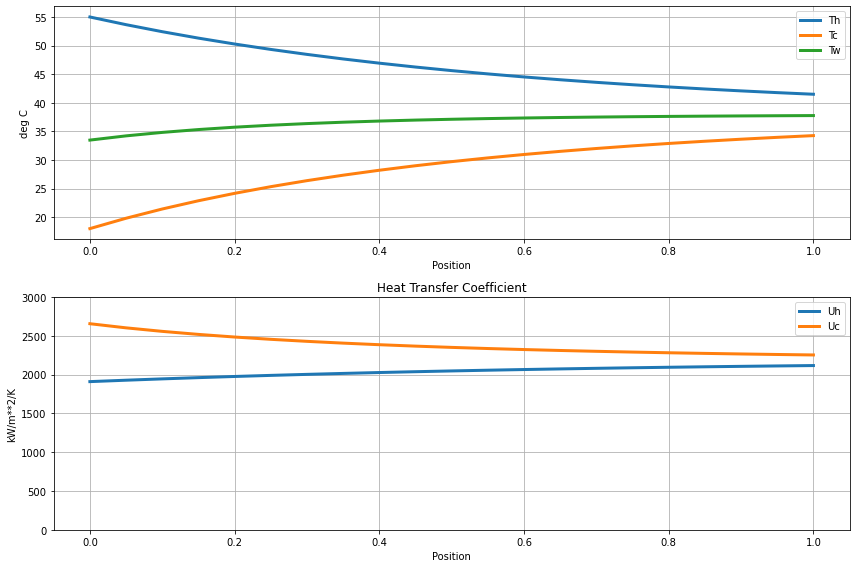

In [2]:
import pyomo.environ as pyo
import pyomo.dae as dae
import pandas as pd 
import matplotlib.pyplot as plt

def double_pipe(config="co-current", qh=600, qc=600, Th_feed=55.0, Tc_feed=18.0):
    """
        Parameters:
            config (string): "co-current" or "counter-current"
            qh (float): hot water flowrate in liters/hour
            qc (float): cold water flowrate in liters/hour
            Th_feed (float): hot water feed temperature in C
            Tc_feed (float): cold water feed temperature in C

            
        Returns a Pyomo model:
            m.z: set of positions, 0 to 1.
            m.Th[z]: hot water temperature profile
            m.Tc[z]: cold water temperature profile
    """
    
    assert config in ["co-current", "counter-current"], "Unrecognized heat exchanger flow configuration"
    y_config = 1 if config=="co-current" else 0

    # known parameter values
    A = 0.5       # square meters
    Cp = 4184     # Joules/kg/deg C    
    rho = 1.0     # 1 kg/liter

    m = pyo.ConcreteModel()
    
    # estimated model parameters
    m.Ch = pyo.Param(initialize=5000.0)
    m.Cc = pyo.Param(initialize=5000.0)

    m.z = dae.ContinuousSet(bounds=(0, 1))

    m.Th = pyo.Var(m.z, initialize=Th_feed)
    m.Tc = pyo.Var(m.z, initialize=Tc_feed)
    m.Tw = pyo.Var(m.z, initialize=(Th_feed + Tc_feed)/2)
    m.Uh = pyo.Var(m.z, initialize=2000)
    m.Uc = pyo.Var(m.z, initialize=2000)
    
    m.dTh = dae.DerivativeVar(m.Th, wrt=m.z)
    m.dTc = dae.DerivativeVar(m.Tc, wrt=m.z)
    
    # feed conditions
    m.Th[1 - y_config].fix(Th_feed)
    m.Tc[0].fix(Tc_feed) 
    
    # local heat transfer coefficients
    @m.Constraint(m.z)
    def heat_transfer_ho(m, z):
        return m.Uh[z] == m.Ch * (qh/3600)**0.8 * prandtl(m.Th[z])**0.4
    
    @m.Constraint(m.z)
    def heat_transfer_cold(m, z):
        return m.Uc[z] == m.Cc * (qc/3600)**0.8 * prandtl(m.Tc[z])**0.4

    # stream energy balances
    @m.Constraint(m.z)
    def dThdz(m, z):
        return rho*Cp*(qh/3600)*m.dTh[z] == (-1)**y_config * m.Uh[z]*A*(m.Th[z] - m.Tw[z])

    @m.Constraint(m.z)
    def dTcdz(m, z):
        return rho*Cp*(qc/3600)*m.dTc[z] == m.Uc[z]*A*(m.Th[z] - m.Tw[z])
    
    # wall energy balance
    @m.Constraint(m.z)
    def wall(m, z):
        return m.Uh[z]*(m.Th[z] - m.Tw[z]) == m.Uc[z]*(m.Tw[z] - m.Tc[z])

    pyo.TransformationFactory('dae.finite_difference').apply_to(m, nfe=20, wrt=m.z)
    return m

    
model = double_pipe("co-current")
pyo.SolverFactory('ipopt').solve(model)

df = pd.DataFrame({
    "Th": [model.Th[z]() for z in model.z],
    "Tw": [model.Tw[z]() for z in model.z],
    "Tc": [model.Tc[z]() for z in model.z],
    "Uh": [model.Uh[z]() for z in model.z],
    "Uc": [model.Uc[z]() for z in model.z],
}, index=model.z)

fig, ax = plt.subplots(2, 1, figsize=(12, 8))
df.plot(y=["Th", "Tc", "Tw"], ax=ax[0], grid=True, lw=3, ylabel="deg C", xlabel="Position")
df.plot(y=["Uh", "Uc"], ax=ax[1], grid=True, ylim=(0, 3000), lw=3, title="Heat Transfer Coefficient",
        ylabel="kW/m**2/K", xlabel="Position")
plt.tight_layout()
